In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

%matplotlib inline
import warnings
warnings.simplefilter("ignore")

### Functions

In [2]:
def check_normality(data: pd.DataFrame,
                    feature: str, 
                    groups: str,
                    log_scale: bool=False) -> None:
    """
    Print histograms with kernel density function, QQ-plot 
    and perform the Shapiro-Wilk test for normality.

    :param data: dataset
    :param feature: numerical feature
    :param groups: categorical feature
    :param log_scale: log transformation of the numerical feature
    :return: None 
    """
    df = []
    for group in data[groups].unique():
        df.append(data[data[groups] == group][feature])
    num = len(df)
    fig, axes = plt.subplots(num, 2, figsize=(10, 4 * num))
    plt.subplots_adjust(wspace=0.25, hspace=0.3)
    for i, col, title in zip(range(num), df, data[groups].unique()):
        param  = col
        if log_scale:
            param = np.log1p(col)
        sns.histplot(param, ax=axes[i][0], kde=True)
        axes[i][0].set_title(f'Distributon of {title}')
        stats.probplot(param, dist="norm", plot=axes[i][1])
        p = round(stats.shapiro(param)[1], 5)
        print(f'Shapiro Test for {title}:\tp = {p}')

In [3]:
def check_log_norm(data: pd.DataFrame,
                   feature: str,
                   groups: str,) -> None:
    """
    Check if the feature distribution is lognormal.

    :param data: dataset
    :param feature: numerical feature
    :param groups: categorical feature
    :return: None 
    """
    df = []
    for group in data[groups].unique():
        df.append(data[data[groups] == group][feature])

    for param, title in zip(df, data[groups].unique()):
        log_feature = stats.lognorm.fit(param)
        p = round(stats.kstest(param, log_feature)[1], 5)
        if p>0.05:
            print(f'Distribution of {title} is lognormal,\tp={p}')
        else:
            print(f'Distribution of {title} is not lognormal,\tp={p}')

In [4]:
def check_variance(data: pd.DataFrame, 
                   feature: str, 
                   groups: str) -> None:
    """
    Perform the Levene test for equal variances
    (separetely for each type of cells).

    :param data: dataset
    :param feature: numerical feature
    :param groups: categorical feature
    :return: None
    """
    df = []
    for group in data[groups].unique():
        df.append(data[data[groups] == group][feature])

    for cell in data['cell_type'].unique():
        p = round(stats.levene(*df)[1], 5)
        if p>0.05:
            print(f'Variances of {cell} are equal in {groups},\tp={p}')
        else:
            print(f'Variances of {cell} are not equal in {groups},\tp={p}')

In [5]:
def mult_comparisons(data: pd.DataFrame,
                     y: str,
                     x: str,
                     hue: str,
                     test_mult: str,
                     test: str=None,
                     log_scale: bool=False) -> None:
    """
    Print multiple boxplots, perform hypothesis testing with 
    multiple comparisons and stat.test between groups (x).

    :param data: dataset
    :param y: numerical feature
    :param x: 1st categorical feature
    :param hue: 2nd categorical feature
    :param test: {'t-test_ind', 'Mann-Whitney'}
    :param test_mult: {a: 'ANOVA one-way', k: 'Kruskal-Wallis'}
    :param log_scale: log transformation of Y scale
    :return: None 
    """
    
    df = []
    for cell in data[x].unique():
        df.append(data[data[x] == cell][y])
    if test_mult == 'a':
        p = stats.f_oneway(*df)[1]
        print(f'ANOVA one-way ({y} btw. {x}): p = {p}\n')
    elif test_mult == 'k':
        p = stats.kruskal(*df)[1]
        print(f'Kruskal-Wallis ({y} btw. {x}): p = {p}\n')

    pairs = [((cell, data[hue].unique()[0]), (cell, data[hue].unique()[1])) 
             for cell in data[x].unique()]

    plt.figure(figsize=(16, 10))
    ax = sns.boxplot(data=data, x=x, y=y, hue=hue)
    if log_scale:
        ax.set_yscale("log")
    ax.set_xlabel('')
    if test:
        annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annotator.configure(test=test, loc='inside')
        annotator.apply_and_annotate();

In [76]:
def bootstrap(feature1: np.array, 
              feature2: np.array, 
              n_iter: int=10_000) -> dict[list, float]:
    """
    Implement bootstrap algorithm for two features
    as mean difference and plot distribution of booted data.

    :param feature1: 1st numerical feature
    :param feature2: 2nd numerical feature
    :return: dict with booted data and 95% confidence level
    """
    n_samp = max(feature1.shape[0], feature2.shape[0])
    res = []
    for i in range(n_iter):
        samp_1 = np.random.choice(feature1, n_samp, replace=True)
        samp_2 = np.random.choice(feature2, n_samp, replace=True)
        res.append(np.mean(samp_2 - samp_1))

    quants = np.quantile(res, 0.025), np.quantile(res, 0.975)
    sns.displot(res, label='Permutation statistic')
    plt.vlines(
        quants, ymin=0, ymax=500, linestyle='--', 
        color='red', label='95% Confidence level')
    plt.title('Histogram of bootstrap difference in means')
    plt.legend();

    return {'boot_data': res, 'quants': quants}

In [7]:
def permutation_test(data: pd.Series, 
                     feature1: np.array, 
                     feature2: np.array, 
                     n1: int, 
                     n2: int, 
                     n_iter: int=10_000) -> tuple[float]:
    """
    Implement permutation algorithm for two features
    and plot distribution of permutated data.

    :param data: dataset
    :param feature1: 1st numerical feature
    :param feature2: 2nd numerical feature
    :param n1: size of 1st permutated array
    :param n2: size of 2nd permutated array
    :return: tuple with p-values (combined, 1st and 2nd features)
    """
    y_1 = []
    y_2 = []
    for i in range(n_iter):
        samp_y_1 = np.random.choice(data.values, n1, replace=True)
        y_1.append(samp_y_1.mean())
        samp_y_2 = np.random.choice(data.values, n2, replace=True)
        y_2.append(samp_y_2.mean())

    p_1 = (feature1.mean() > y_1).sum() / n_iter
    p_2 = (feature2.mean() > y_2).sum() / n_iter
    p = stats.combine_pvalues(
        [p_1, p_2], method='fisher', weights=None
    )[1]

    sns.displot(y_1, label='Permutation statistic')
    plt.vlines(
        feature1.mean(), ymin=0, ymax=300, 
        linestyle='--', color='red', label='Sample statistic'
    )
    plt.title('Distribution of permuted feature1')
    plt.legend()
    sns.displot(y_2, label='Permutation statistic')
    plt.vlines(
        feature2.mean(), ymin=0, ymax=300, 
        linestyle='--', color='red', label='Sample statistic'
    )
    plt.title('Distribution of permuted feature2')
    plt.legend()

    return (p, p_1, p_2)

___

In [8]:
data = pd.read_csv('community_dataset.csv')
data

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891,185,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891,209,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891,254,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891,156,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891,194,elder_group
...,...,...,...,...,...,...,...,...,...
269437,928.977004,720.993469,9.667603,29.866927,community_6,Stroma cells,983,258,young_group
269438,651.888363,1040.658354,20.298864,40.847738,community_2,Immune type 1,983,160,young_group
269439,754.601247,688.651619,10.351852,22.967870,community_3,Unclassified,983,190,young_group
269440,901.768538,700.092692,11.459289,57.536165,community_4,Stroma cells,983,535,young_group


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269442 entries, 0 to 269441
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance_to_vasculature   269442 non-null  float64
 1   distance_to_largest_cell  269442 non-null  float64
 2   immune_marker_1           269442 non-null  float64
 3   immune_marker_2           269442 non-null  float64
 4   cell_interaction          269442 non-null  object 
 5   cell_type                 269442 non-null  object 
 6   case_id                   269442 non-null  int64  
 7   area_of_cell              269442 non-null  int64  
 8   age_group                 269442 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 18.5+ MB


In [10]:
data.describe()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,case_id,area_of_cell
count,269442.000000,269442.000000,269442.000000,269442.000000,269442.000000,269442.000000
mean,929.070855,763.923963,20.161576,77.737352,543.799330,252.588887
std,232.025464,143.529254,8.878973,62.181699,339.463422,154.717140
min,576.000265,576.000340,0.022423,0.022770,40.000000,45.000000
25%,749.548219,666.386842,14.059163,32.423038,199.000000,180.000000
50%,889.336304,731.602653,19.167223,53.691949,693.000000,230.000000
75%,1067.406152,822.422538,24.883889,114.728847,708.000000,295.000000
max,2057.201309,3181.140602,119.474602,1267.883744,983.000000,6807.000000


In [11]:
data.describe(include=[object])

,cell_interaction,cell_type,age_group
count,269442,269442,269442
unique,6,8,2
top,community_4,Stroma cells,young_group
freq,80969,173192,188900


In [12]:
display(data['cell_interaction'].value_counts(normalize=True))
display(data['cell_type'].value_counts(normalize=True))
display(data['age_group'].value_counts(normalize=True))

community_4    0.300506
community_2    0.191069
community_1    0.180061
community_5    0.129456
community_6    0.099862
community_3    0.099045
Name: cell_interaction, dtype: float64

Stroma cells     0.642780
Unclassified     0.248536
Immune type 2    0.060139
Immune type 1    0.020691
Blood cells      0.010459
Bone cells       0.009483
Largest cells    0.007378
Vasculature      0.000534
Name: cell_type, dtype: float64

young_group    0.701079
elder_group    0.298921
Name: age_group, dtype: float64

___
# Problem 1.
#### a) Есть ли стат-значимость между типом клетки и pазмером клетки (area_of_cell), добавьте hue по возрастным группам.

##### Проверка нормальности распределения и равенства дисперсий в группах.
tests:
- normality [Shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
- check lognorm distribution [Kolmogorov-Smirnov test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)
- variances [Levene](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html)

Shapiro Test for Stroma cells:	p = 0.0
Shapiro Test for Unclassified:	p = 0.0
Shapiro Test for Immune type 2:	p = 0.0
Shapiro Test for Blood cells:	p = 0.0
Shapiro Test for Bone cells:	p = 0.0005
Shapiro Test for Largest cells:	p = 0.0
Shapiro Test for Immune type 1:	p = 0.0
Shapiro Test for Vasculature:	p = 0.23131


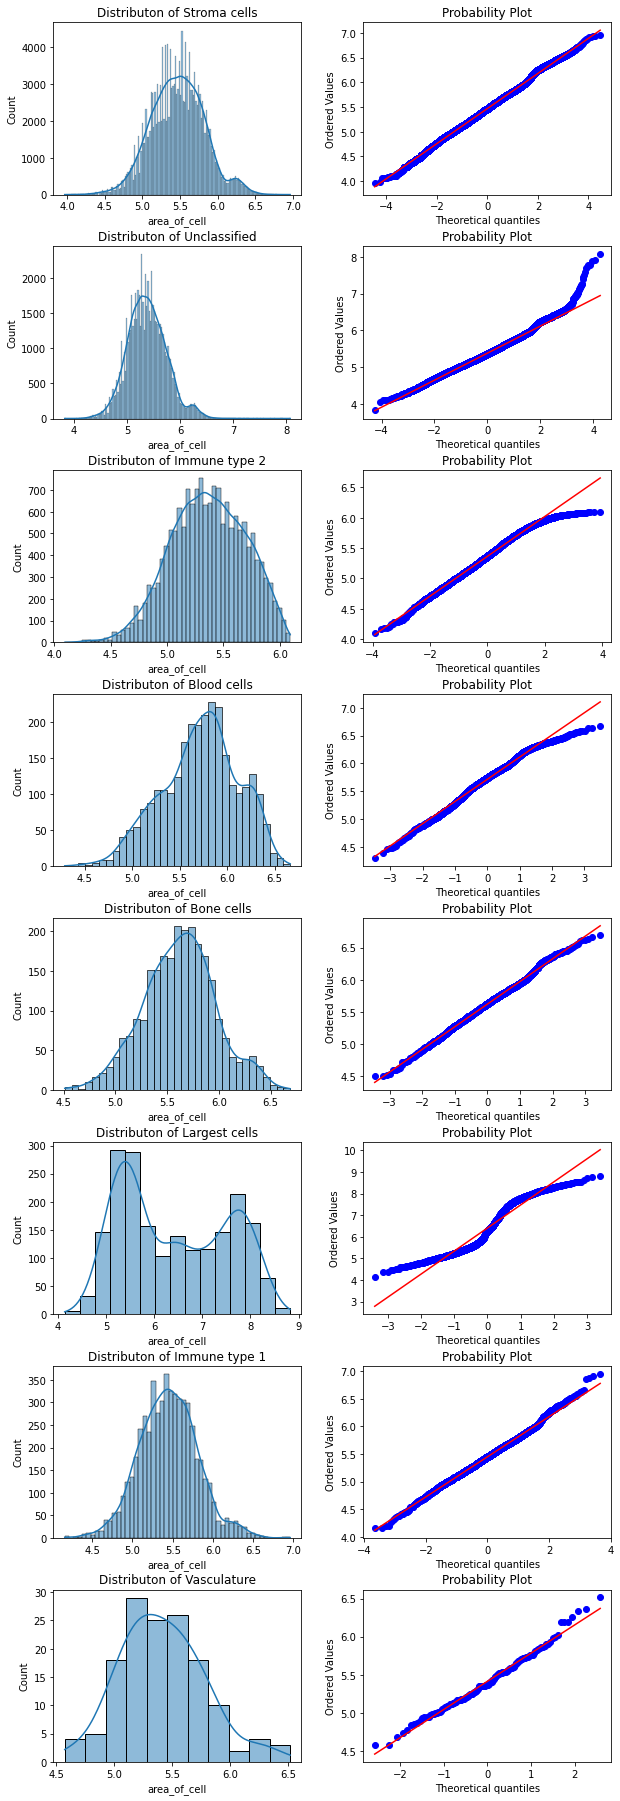

In [13]:
check_normality(data, feature='area_of_cell', groups='cell_type', log_scale=True)

In [14]:
check_log_norm(data, feature='area_of_cell', groups='cell_type')

Distribution of Stroma cells is lognormal,	p=0.07407
Distribution of Unclassified is lognormal,	p=0.07407
Distribution of Immune type 2 is lognormal,	p=0.07407
Distribution of Blood cells is lognormal,	p=0.07431
Distribution of Bone cells is lognormal,	p=0.07425
Distribution of Largest cells is not lognormal,	p=0.0
Distribution of Immune type 1 is lognormal,	p=0.07419
Distribution of Vasculature is not lognormal,	p=0.0


In [15]:
check_variance(data, feature='area_of_cell', groups='age_group')

Variances of Stroma cells are not equal in age_group,	p=0.0
Variances of Unclassified are not equal in age_group,	p=0.0
Variances of Immune type 2 are not equal in age_group,	p=0.0
Variances of Blood cells are not equal in age_group,	p=0.0
Variances of Bone cells are not equal in age_group,	p=0.0
Variances of Largest cells are not equal in age_group,	p=0.0
Variances of Immune type 1 are not equal in age_group,	p=0.0
Variances of Vasculature are not equal in age_group,	p=0.0


**Вывод:** Распределения всех фичей логнормальные или нормальные, только гигантские клетки бимодальные (вероятно, отличаются по возрасту). Но в группах по возрасту дисперсии для каждого типа клеток не равны, поэтому используем непараметрические тесты.  

**H0** → µ1 = µ2 = µ3 = µ4 = µ5 = µ6 = µ7 = µ8  
**H1** → µ1 != µ2 != µ3 != µ4 != µ5 != µ6 != µ7 != µ8  

tests: 
- for 2 groups [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) two-sided H1
- for several groups [Kruskal-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)
- [visualizing](https://github.com/trevismd/statannotations)  

alpha = 0.05

Kruskal-Wallis (area_of_cell btw. cell_type): p = 0.0

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Unclassified_elder_group vs. Unclassified_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:6.329e-13 U_stat=4.958e+08
Stroma cells_elder_group vs. Stroma cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.673e-107 U_stat=2.715e+09
Immune type 2_elder_group vs. Immune type 2_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:3.074e-16 U_stat=3.510e+07
Blood cells_elder_group vs. Blood cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:8.017e-01 U_stat=5.942e+05
Bone cells_elder_group vs. Bone cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:3.789e-03 U_stat=4.619e+05
Largest cells_elder_group vs. Largest cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:2.954e-73 U_stat=2.573e+05
Immune ty

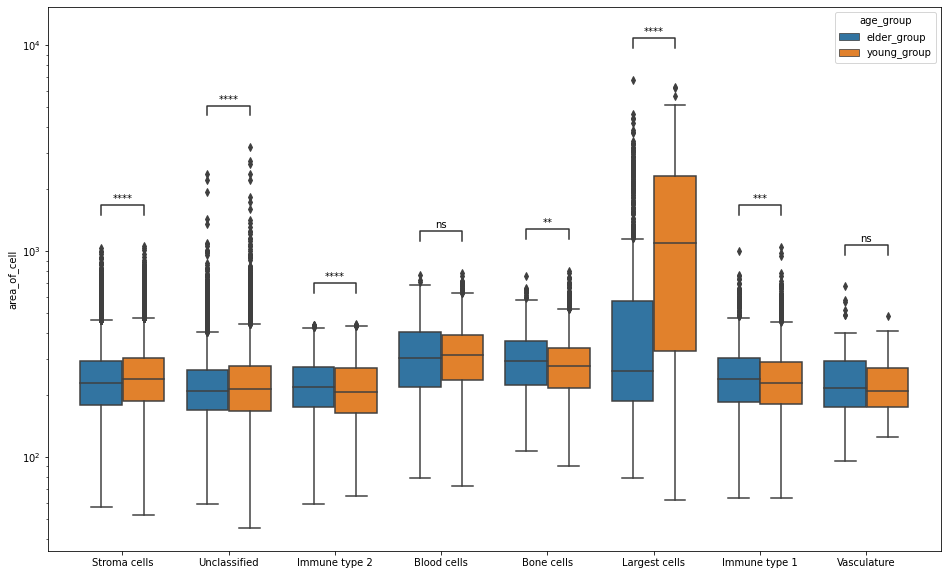

In [16]:
mult_comparisons(
    data, x='cell_type', y='area_of_cell', hue='age_group', 
    test='Mann-Whitney', test_mult='k', log_scale=True
)

**Вывод:** H0 отклоняем - имеются различия размеров клеток между разными типами клеток. Кроме того, для большинства клеток имеются различия в размере в зависимости от возрастной группы.  

Проводим post-hoc анализ отдельно для молодых и пожилых пациентов.  
Имеются различия в размере между всеми клетками, как у молодых, так и у пожилых пациентов. За исключением сосудистых клеток, размер которых статистически значимо не отличается от размера иммунных, стромальных и неклассифицируемых клеток в обеих возрастных группах, а также неклассифицируемых и иммунных клеток 2 типа у пожилых пациентов (см. ниже).

In [17]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'young_group']['area_of_cell'],
    data[data['age_group'] == 'young_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1        group2     meandiff  p-adj    lower      upper    reject
--------------------------------------------------------------------------
  Blood cells    Bone cells   -35.9044    0.0   -48.1053   -23.7036   True
  Blood cells Immune type 1   -81.4714    0.0   -92.1373   -70.8055   True
  Blood cells Immune type 2  -104.7531    0.0  -114.3131   -95.1931   True
  Blood cells Largest cells  1134.1576    0.0  1119.2653  1149.0498   True
  Blood cells  Stroma cells   -71.7286    0.0   -80.3026   -63.1546   True
  Blood cells  Unclassified   -90.9009    0.0   -99.6215   -82.1804   True
  Blood cells   Vasculature   -95.1112    0.0  -152.2253   -37.9971   True
   Bone cells Immune type 1    -45.567    0.0    -56.439    -34.695   True
   Bone cells Immune type 2   -68.8487    0.0   -78.6381   -59.0593   True
   Bone cells Largest cells   1170.062    0.0  1155.0215  1185.1025   True
   Bone cells  Stroma cel

In [18]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'elder_group']['area_of_cell'],
    data[data['age_group'] == 'elder_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells  -19.6203 0.2599  -44.7888    5.5483  False
  Blood cells Immune type 1  -72.4642   -0.0  -91.4632  -53.4652   True
  Blood cells Immune type 2 -100.4837   -0.0  -117.522  -83.4454   True
  Blood cells Largest cells  285.5451   -0.0  264.7472   306.343   True
  Blood cells  Stroma cells  -83.3607   -0.0  -99.9339  -66.7875   True
  Blood cells  Unclassified -102.2467   -0.0 -118.9063  -85.5871   True
  Blood cells   Vasculature  -83.4573    0.0 -125.9961  -40.9184   True
   Bone cells Immune type 1  -52.8439   -0.0  -74.0868  -31.6011   True
   Bone cells Immune type 2  -80.8634   -0.0 -100.3724  -61.3545   True
   Bone cells Largest cells  305.1654   -0.0  282.2996  328.0312   True
   Bone cells  Stroma cells  -63.7404   -0.0  -82.8445  -44.6363

#### б) Есть ли стат-значимость между типом клетки и экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

##### Проверка нормальности распределения и равенства дисперсий в группах для иммунного маркера 1.
Тесты те же.

Shapiro Test for Stroma cells:	p = 0.0
Shapiro Test for Unclassified:	p = 0.0
Shapiro Test for Immune type 2:	p = 0.0
Shapiro Test for Blood cells:	p = 0.0
Shapiro Test for Bone cells:	p = 0.01276
Shapiro Test for Largest cells:	p = 0.0
Shapiro Test for Immune type 1:	p = 2e-05
Shapiro Test for Vasculature:	p = 0.62257


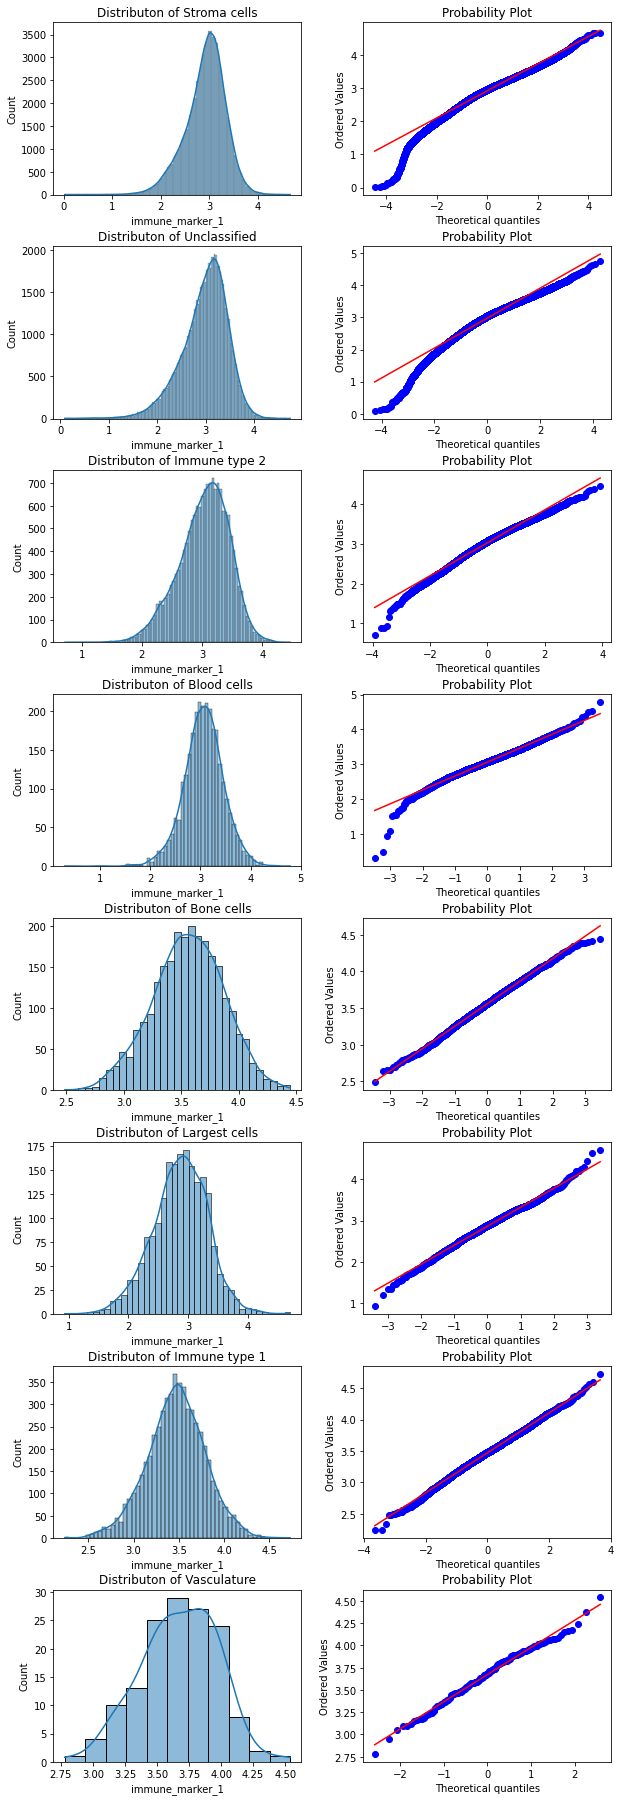

In [19]:
check_normality(
    data, feature='immune_marker_1', 
    groups='cell_type', log_scale=True
)

In [20]:
check_log_norm(data, feature='immune_marker_1', groups='cell_type')

Distribution of Stroma cells is lognormal,	p=0.07413
Distribution of Unclassified is lognormal,	p=0.07414
Distribution of Immune type 2 is lognormal,	p=0.07407
Distribution of Blood cells is lognormal,	p=0.07431
Distribution of Bone cells is lognormal,	p=0.07425
Distribution of Largest cells is lognormal,	p=0.0743
Distribution of Immune type 1 is lognormal,	p=0.07419
Distribution of Vasculature is lognormal,	p=0.08067


In [21]:
check_variance(data, feature='immune_marker_1', groups='age_group')

Variances of Stroma cells are not equal in age_group,	p=0.0
Variances of Unclassified are not equal in age_group,	p=0.0
Variances of Immune type 2 are not equal in age_group,	p=0.0
Variances of Blood cells are not equal in age_group,	p=0.0
Variances of Bone cells are not equal in age_group,	p=0.0
Variances of Largest cells are not equal in age_group,	p=0.0
Variances of Immune type 1 are not equal in age_group,	p=0.0
Variances of Vasculature are not equal in age_group,	p=0.0


**Вывод:** Распределения всех фичей логнормальные. Но в группах по возрасту дисперсии для каждого типа клеток не равны, поэтому используем непараметрические тесты.  

**H0** → µ1 = µ2 = µ3 = µ4 = µ5 = µ6 = µ7 = µ8  
**H1** → µ1 != µ2 != µ3 != µ4 != µ5 != µ6 != µ7 != µ8  

tests: 
- for 2 groups [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) two-sided H1
- for several groups [Kruskal-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)
- [visualizing](https://github.com/trevismd/statannotations)  

alpha = 0.05

Kruskal-Wallis (immune_marker_1 btw. cell_type): p = 0.0

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Unclassified_elder_group vs. Unclassified_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=6.811e+08
Stroma cells_elder_group vs. Stroma cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.967e+09
Immune type 2_elder_group vs. Immune type 2_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.388e+07
Blood cells_elder_group vs. Blood cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.806e-27 U_stat=7.804e+05
Bone cells_elder_group vs. Bone cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.974e-17 U_stat=5.371e+05
Largest cells_elder_group vs. Largest cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:8.310e-76 U_stat=7.216e+05
Immune 

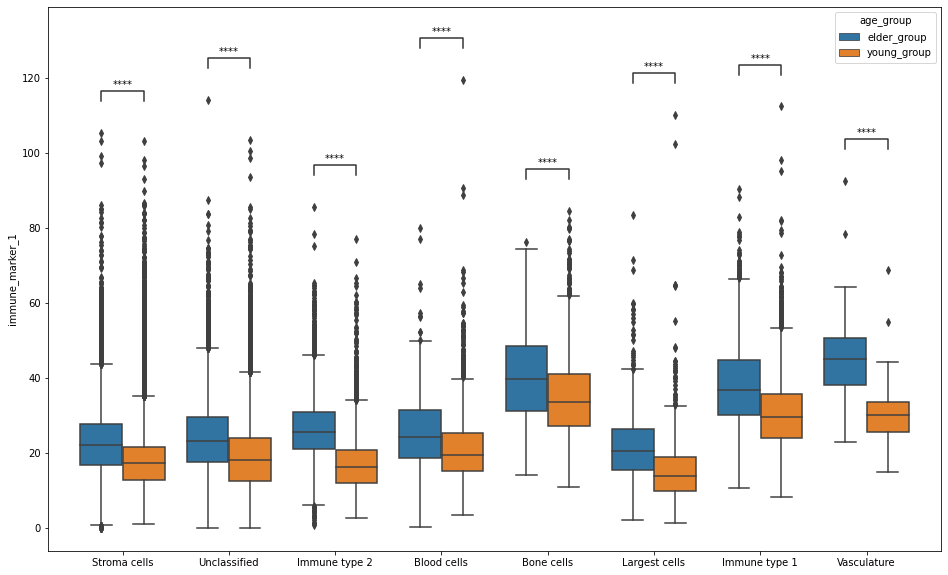

In [22]:
mult_comparisons(
    data, x='cell_type', y='immune_marker_1', hue='age_group', 
    test='Mann-Whitney', test_mult='k'
)

**Вывод:** H0 отклоняем - имеются различия иммунных маркеров между разными типами клеток. Кроме того, для всех клеток имеются различия в маркере 1 в зависимости от возрастной группы.  

Проводим post-hoc анализ отдельно для молодых и пожилых пациентов.  
Имеются различия в экспрессии иммунного маркера 1 между всеми клетками, как у молодых, так и у пожилых пациентов.  
За исключением сосудистых и иммунных клеток 1 типа у молодых, а также кровяных и иммунных клеток 2 типа, гигантских и стромальных леток у пожилых пациентов (см. ниже).

In [23]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'young_group']['immune_marker_1'],
    data[data['age_group'] == 'young_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------
  Blood cells    Bone cells  13.8462   0.0  13.1419  14.5505   True
  Blood cells Immune type 1   9.3684   0.0   8.7527   9.9841   True
  Blood cells Immune type 2  -4.0639   0.0  -4.6157   -3.512   True
  Blood cells Largest cells  -5.6543   0.0  -6.5139  -4.7946   True
  Blood cells  Stroma cells  -3.4033   0.0  -3.8982  -2.9083   True
  Blood cells  Unclassified  -2.2282   0.0  -2.7316  -1.7248   True
  Blood cells   Vasculature   9.5532   0.0   6.2563  12.8501   True
   Bone cells Immune type 1  -4.4778   0.0  -5.1054  -3.8503   True
   Bone cells Immune type 2 -17.9101   0.0 -18.4752  -17.345   True
   Bone cells Largest cells -19.5005   0.0 -20.3687 -18.6323   True
   Bone cells  Stroma cells -17.2495   0.0 -17.7591 -16.7398   True
   Bone cells  Unclassified -16.0744   0.0 -16.5

In [24]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'elder_group']['immune_marker_1'],
    data[data['age_group'] == 'elder_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2    meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------
  Blood cells    Bone cells  14.3405   -0.0  12.5445  16.1364   True
  Blood cells Immune type 1  12.4143   -0.0  11.0586    13.77   True
  Blood cells Immune type 2    0.539  0.882  -0.6767   1.7548  False
  Blood cells Largest cells  -3.9117   -0.0  -5.3957  -2.4276   True
  Blood cells  Stroma cells   -3.204   -0.0  -4.3866  -2.0214   True
  Blood cells  Unclassified  -1.7789 0.0002  -2.9677  -0.5902   True
  Blood cells   Vasculature  19.4955   -0.0  16.4601  22.5309   True
   Bone cells Immune type 1  -1.9262  0.003   -3.442  -0.4104   True
   Bone cells Immune type 2 -13.8014   -0.0 -15.1935 -12.4093   True
   Bone cells Largest cells -18.2521   -0.0 -19.8837 -16.6205   True
   Bone cells  Stroma cells -17.5445   -0.0 -18.9076 -16.1813   True
   Bone cells  Unclassified -16.11

##### Проверка нормальности распределения и равенства дисперсий в группах для иммунного маркера 2.
Тесты те же.

Shapiro Test for Stroma cells:	p = 0.0
Shapiro Test for Unclassified:	p = 0.0
Shapiro Test for Immune type 2:	p = 0.0
Shapiro Test for Blood cells:	p = 2e-05
Shapiro Test for Bone cells:	p = 0.0
Shapiro Test for Largest cells:	p = 1e-05
Shapiro Test for Immune type 1:	p = 0.0
Shapiro Test for Vasculature:	p = 0.00332


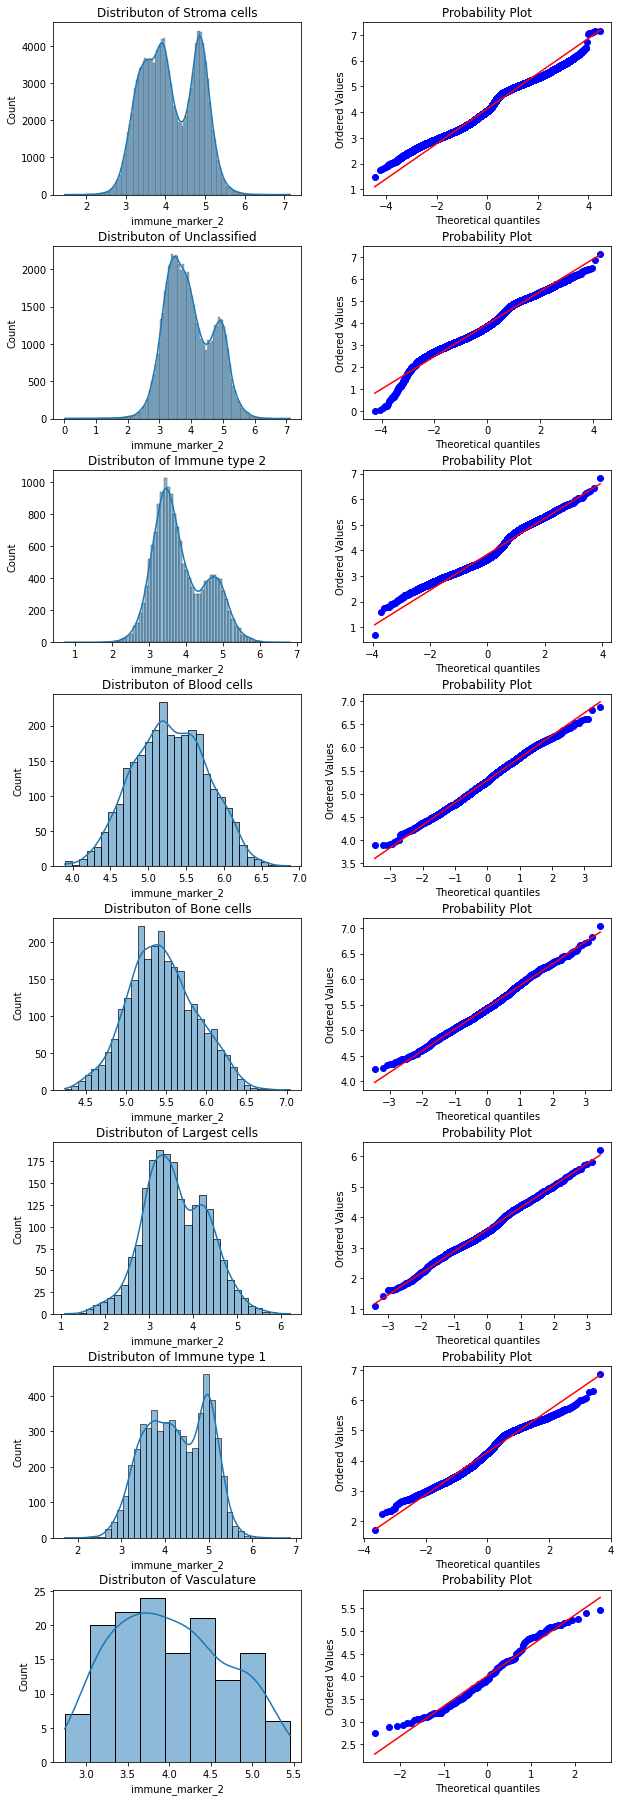

In [25]:
check_normality(
    data, feature='immune_marker_2', 
    groups='cell_type', log_scale=True
)

In [26]:
check_log_norm(data, feature='immune_marker_2', groups='cell_type')

Distribution of Stroma cells is lognormal,	p=0.07407
Distribution of Unclassified is not lognormal,	p=0.0
Distribution of Immune type 2 is not lognormal,	p=0.0
Distribution of Blood cells is lognormal,	p=0.07431
Distribution of Bone cells is not lognormal,	p=0.01134
Distribution of Largest cells is lognormal,	p=0.0743
Distribution of Immune type 1 is not lognormal,	p=0.0
Distribution of Vasculature is lognormal,	p=0.08067


In [27]:
check_variance(data, feature='immune_marker_2', groups='age_group')

Variances of Stroma cells are not equal in age_group,	p=0.0
Variances of Unclassified are not equal in age_group,	p=0.0
Variances of Immune type 2 are not equal in age_group,	p=0.0
Variances of Blood cells are not equal in age_group,	p=0.0
Variances of Bone cells are not equal in age_group,	p=0.0
Variances of Largest cells are not equal in age_group,	p=0.0
Variances of Immune type 1 are not equal in age_group,	p=0.0
Variances of Vasculature are not equal in age_group,	p=0.0


**Вывод:** Распределения части фичей логнормальные, части бимодальные (верояно, различия по возрасту). Но в группах по возрасту дисперсии для каждого типа клеток не равны, поэтому используем непараметрические тесты.  

**H0** → µ1 = µ2 = µ3 = µ4 = µ5 = µ6 = µ7 = µ8  
**H1** → µ1 != µ2 != µ3 != µ4 != µ5 != µ6 != µ7 != µ8  

tests: 
- for 2 groups [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) two-sided H1
- for several groups [Kruskal-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)
- [visualizing](https://github.com/trevismd/statannotations)  

alpha = 0.05

Kruskal-Wallis (immune_marker_2 btw. cell_type): p = 0.0

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Unclassified_elder_group vs. Unclassified_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.240e-87 U_stat=4.656e+08
Stroma cells_elder_group vs. Stroma cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.331e+09
Immune type 2_elder_group vs. Immune type 2_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:4.999e-10 U_stat=3.083e+07
Blood cells_elder_group vs. Blood cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:8.302e-01 U_stat=6.020e+05
Bone cells_elder_group vs. Bone cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.944e-04 U_stat=3.730e+05
Largest cells_elder_group vs. Largest cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:4.954e-01 U_stat=4.961e+05
Immune 

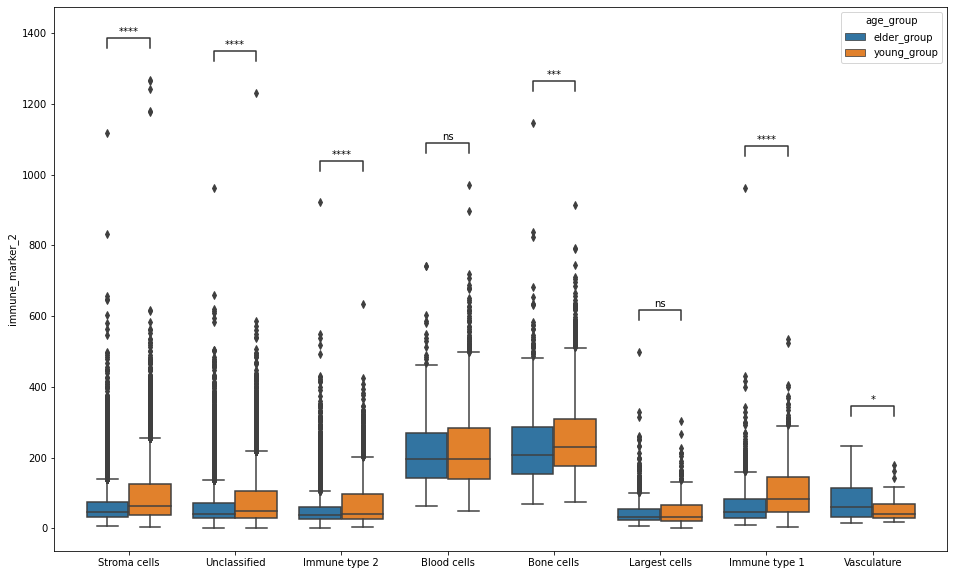

In [28]:
mult_comparisons(
    data, x='cell_type', y='immune_marker_2', hue='age_group', 
    test='Mann-Whitney', test_mult='k'
)

**Вывод:** H0 отклоняем - имеются различия иммунного маркера 2 между разными типами клеток. Кроме того, практически для всех клеток имеются различия в маркере 2 в зависимости от возрастной группы.  

Проводим post-hoc анализ отдельно для молодых и пожилых пациентов.  
Имеются различия в экспрессии иммунного маркера 2 между всеми клетками, как у молодых, так и у пожилых пациентов.  
За исключением сосудистых и иммунных клеток 2 типа, стромальных и неклассифицируемых у молодых, а также сосудистых и иммунных клеток 1 типа, стромальных и неклассифицируемых у пожилых пациентов (см. ниже).

In [29]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'young_group']['immune_marker_2'],
    data[data['age_group'] == 'young_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells   33.2401    0.0   27.9645   38.5158   True
  Blood cells Immune type 1 -123.8008    0.0 -128.4128 -119.1888   True
  Blood cells Immune type 2 -157.8012    0.0 -161.9349 -153.6674   True
  Blood cells Largest cells -176.8497    0.0 -183.2891 -170.4102   True
  Blood cells  Stroma cells -140.0269    0.0 -143.7343 -136.3195   True
  Blood cells  Unclassified -151.4338    0.0 -155.2046  -147.663   True
  Blood cells   Vasculature -169.1114    0.0 -193.8076 -144.4152   True
   Bone cells Immune type 1 -157.0409    0.0  -161.742 -152.3399   True
   Bone cells Immune type 2 -191.0413    0.0 -195.2742 -186.8084   True
   Bone cells Largest cells -210.0898    0.0 -216.5933 -203.5863   True
   Bone cells  Stroma cells  -173.267    0.0 -177.0847 -169.4493

In [30]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'elder_group']['immune_marker_2'],
    data[data['age_group'] == 'elder_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells    24.563    0.0   13.5361   35.5898   True
  Blood cells Immune type 1 -154.3387   -0.0 -162.6626 -146.0148   True
  Blood cells Immune type 2 -164.1216   -0.0 -171.5864 -156.6568   True
  Blood cells Largest cells -172.2713   -0.0 -181.3833 -163.1594   True
  Blood cells  Stroma cells -154.8736   -0.0 -162.1347 -147.6125   True
  Blood cells  Unclassified -157.8616   -0.0 -165.1605 -150.5627   True
  Blood cells   Vasculature -143.5267   -0.0 -162.1638 -124.8895   True
   Bone cells Immune type 1 -178.9017   -0.0 -188.2086 -169.5947   True
   Bone cells Immune type 2 -188.6845   -0.0 -197.2318 -180.1373   True
   Bone cells Largest cells -196.8343   -0.0 -206.8523 -186.8163   True
   Bone cells  Stroma cells -179.4366   -0.0 -187.8064 -171.0667

#### б) Есть ли стат-значимость между типом клетки и дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.

##### Проверка нормальности распределения и равенства дисперсий в группах для расстояния до сосудов.
Тесты те же.

Shapiro Test for Stroma cells:	p = 0.0
Shapiro Test for Unclassified:	p = 0.0
Shapiro Test for Immune type 2:	p = 0.0
Shapiro Test for Blood cells:	p = 0.0
Shapiro Test for Bone cells:	p = 0.0
Shapiro Test for Largest cells:	p = 0.0
Shapiro Test for Immune type 1:	p = 0.0
Shapiro Test for Vasculature:	p = 0.0


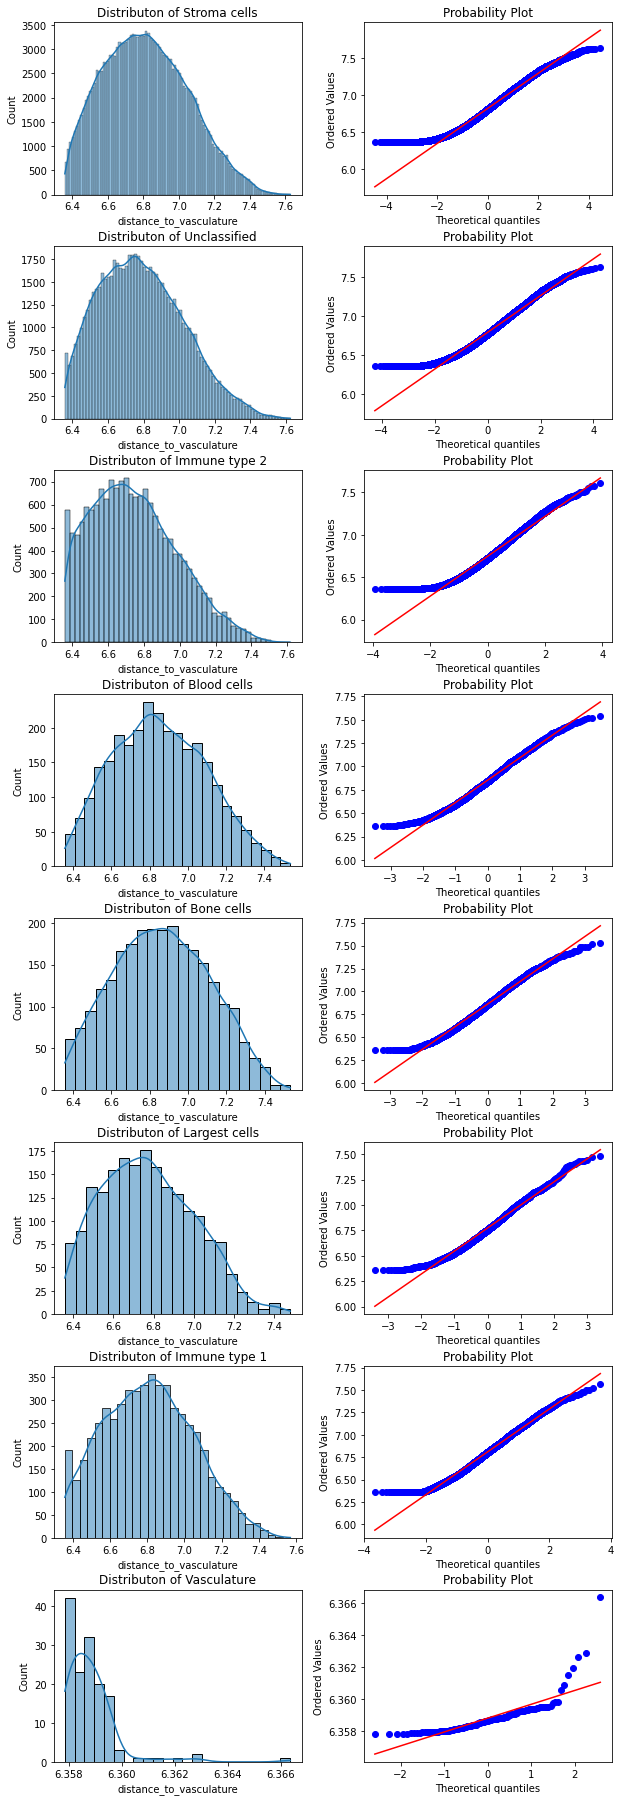

In [31]:
check_normality(
    data, feature='distance_to_vasculature', 
    groups='cell_type', log_scale=True
)

In [32]:
check_log_norm(
    data, feature='distance_to_vasculature', groups='cell_type'
)

Distribution of Stroma cells is not lognormal,	p=0.0
Distribution of Unclassified is not lognormal,	p=0.0
Distribution of Immune type 2 is not lognormal,	p=0.0
Distribution of Blood cells is not lognormal,	p=0.0
Distribution of Bone cells is not lognormal,	p=0.0
Distribution of Largest cells is not lognormal,	p=0.0
Distribution of Immune type 1 is not lognormal,	p=0.0
Distribution of Vasculature is not lognormal,	p=0.0


**Вывод:** Гипотеза о нормальности распределений отвергнута, распределения фичей значительно скошены влево, поэтому используем непараметрические тесты.  

**H0** → µ1 = µ2 = µ3 = µ4 = µ5 = µ6 = µ7 = µ8  
**H1** → µ1 != µ2 != µ3 != µ4 != µ5 != µ6 != µ7 != µ8  

tests: 
- for 2 groups [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) two-sided H1
- for several groups [Kruskal-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)
- [visualizing](https://github.com/trevismd/statannotations)  

alpha = 0.05

Kruskal-Wallis (distance_to_vasculature btw. cell_type): p = 0.0

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Unclassified_elder_group vs. Unclassified_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.270e+08
Stroma cells_elder_group vs. Stroma cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.795e+09
Immune type 2_elder_group vs. Immune type 2_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.110e+07
Blood cells_elder_group vs. Blood cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:9.418e-53 U_stat=3.421e+05
Bone cells_elder_group vs. Bone cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:2.128e-47 U_stat=2.289e+05
Largest cells_elder_group vs. Largest cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:8.567e-36 U_stat=3.287e+05

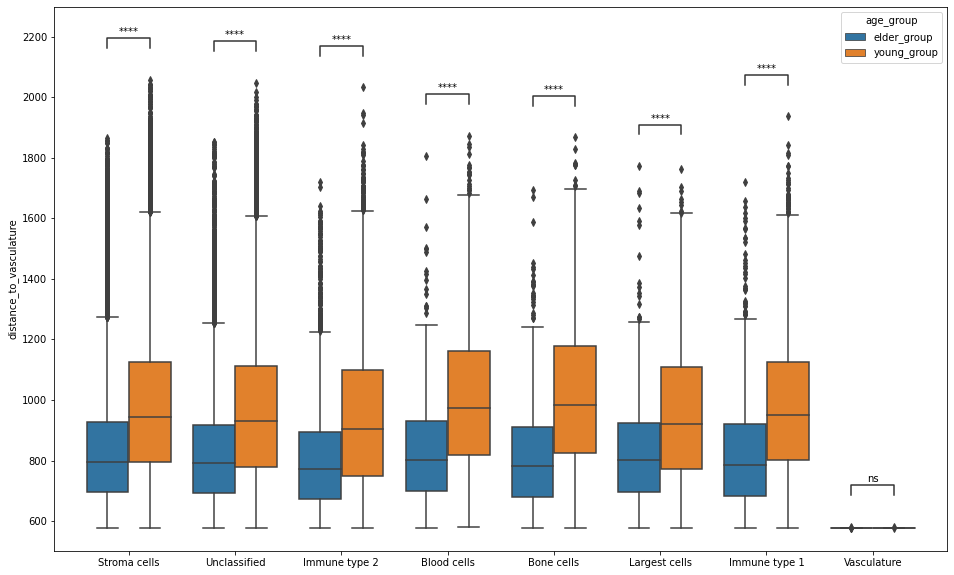

In [33]:
mult_comparisons(
    data, x='cell_type', y='distance_to_vasculature', hue='age_group', 
    test='Mann-Whitney', test_mult='k'
)

**Вывод:** H0 отклоняем - имеются различия в расстоянии до сосудов между разными типами клеток. Кроме того, для всех клеток имеются различия в расстоянии до сосудов в зависимости от возрастной группы (судя по боксплотам, у молодых все клетки расположены дольше от сосудов).  

Проводим post-hoc анализ отдельно для молодых и пожилых пациентов.  
Имеются различия в расстоянии дососудов между всеми клетками у молодых пациентов. За исключением кровяных и костных клеток, стромальных и иммунных, гигантских и иммунных, гиганстких и неклассифицируемых.  
У пожилых расстояния до сосудов значимо отличаются только в для большинства иммунных клеток и комбинации стромальных и неклассифицируемых (см. ниже).

In [34]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'young_group']['distance_to_vasculature'],
    data[data['age_group'] == 'young_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells    7.3344 0.9698  -14.2213   28.8902  False
  Blood cells Immune type 1  -28.3649 0.0001  -47.2089    -9.521   True
  Blood cells Immune type 2  -63.2781    0.0  -80.1681   -46.388   True
  Blood cells Largest cells  -54.0825    0.0  -80.3932  -27.7718   True
  Blood cells  Stroma cells  -27.7493    0.0  -42.8973  -12.6013   True
  Blood cells  Unclassified  -41.2265    0.0  -56.6334  -25.8195   True
  Blood cells   Vasculature -428.8679    0.0 -529.7736 -327.9622   True
   Bone cells Immune type 1  -35.6994    0.0  -54.9073  -16.4914   True
   Bone cells Immune type 2  -70.6125    0.0  -87.9078  -53.3172   True
   Bone cells Largest cells  -61.4169    0.0  -87.9896  -34.8443   True
   Bone cells  Stroma cells  -35.0837    0.0  -50.6823  -19.4851

In [35]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'elder_group']['distance_to_vasculature'],
    data[data['age_group'] == 'elder_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells   -5.4324 0.9998  -41.7017   30.8369  False
  Blood cells Immune type 1  -19.1134 0.4044  -46.4921    8.2653  False
  Blood cells Immune type 2  -36.7451 0.0002  -61.2982  -12.1919   True
  Blood cells Largest cells   -8.0523 0.9924  -38.0232   21.9186  False
  Blood cells  Stroma cells   -6.1502 0.9941  -30.0331   17.7327  False
  Blood cells  Unclassified  -14.1062 0.6331  -38.1137    9.9012  False
  Blood cells   Vasculature -260.3747   -0.0 -321.6756 -199.0738   True
   Bone cells Immune type 1   -13.681 0.8776  -44.2932   16.9312  False
   Bone cells Immune type 2  -31.3127 0.0169  -59.4262   -3.1992   True
   Bone cells Largest cells   -2.6199    1.0  -35.5709   30.3311  False
   Bone cells  Stroma cells   -0.7179    1.0  -28.2479   26.8122

##### Проверка нормальности распределения и равенства дисперсий в группах для расстояния до крупных клеток.
Тесты те же.

Shapiro Test for Stroma cells:	p = 0.0
Shapiro Test for Unclassified:	p = 0.0
Shapiro Test for Immune type 2:	p = 0.0
Shapiro Test for Blood cells:	p = 0.0
Shapiro Test for Bone cells:	p = 0.0
Shapiro Test for Largest cells:	p = 0.0
Shapiro Test for Immune type 1:	p = 0.0
Shapiro Test for Vasculature:	p = 0.0


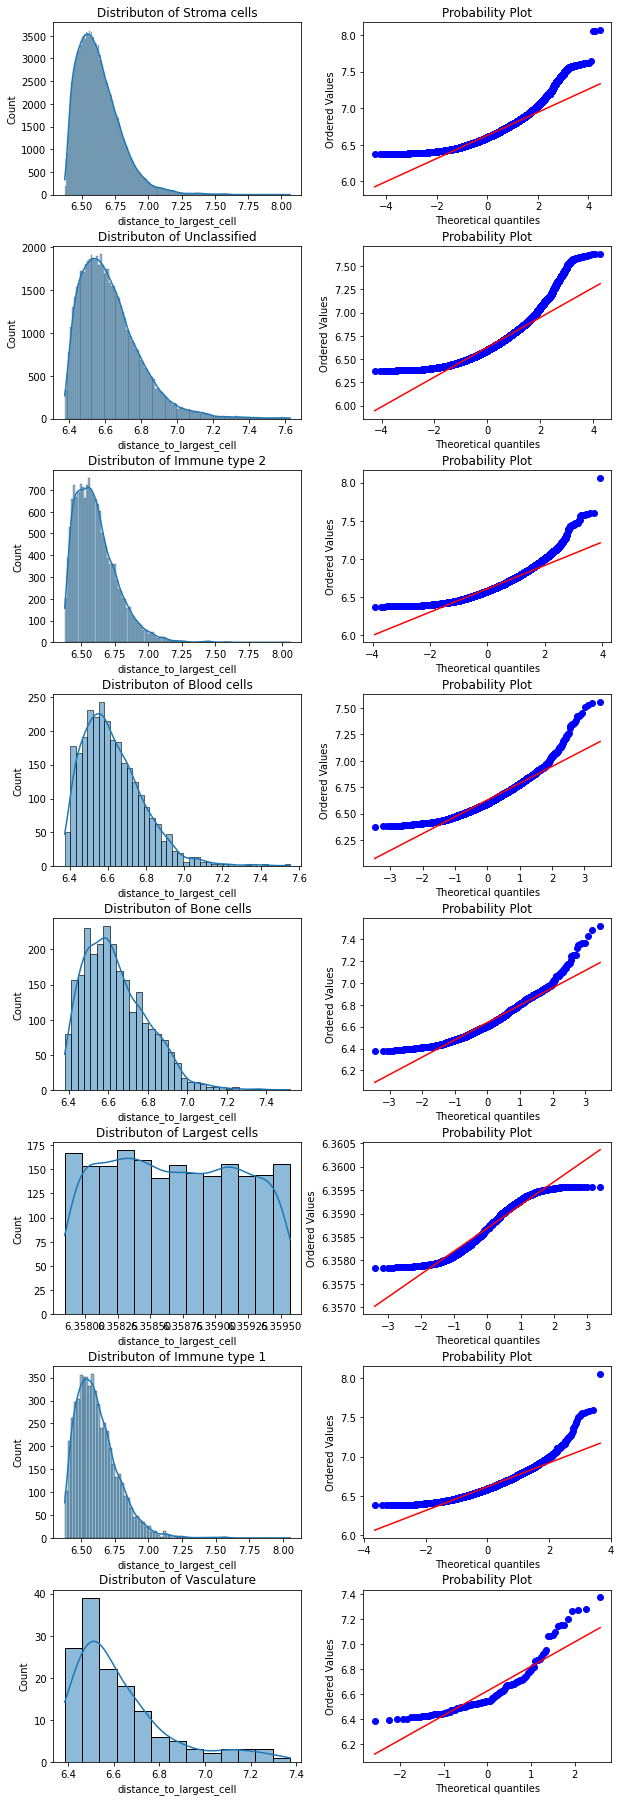

In [36]:
check_normality(
    data, feature='distance_to_largest_cell', 
    groups='cell_type', log_scale=True
)

In [37]:
check_log_norm(
    data, feature='distance_to_largest_cell', groups='cell_type'
)

Distribution of Stroma cells is not lognormal,	p=0.0
Distribution of Unclassified is not lognormal,	p=0.0
Distribution of Immune type 2 is not lognormal,	p=0.0
Distribution of Blood cells is not lognormal,	p=0.0
Distribution of Bone cells is not lognormal,	p=0.0
Distribution of Largest cells is not lognormal,	p=0.0
Distribution of Immune type 1 is not lognormal,	p=0.0
Distribution of Vasculature is not lognormal,	p=0.0


**Вывод:** Гипотеза о нормальности распределений отвергнута, распределения фичей значительно скошены влево, поэтому используем непараметрические тесты.  

**H0** → µ1 = µ2 = µ3 = µ4 = µ5 = µ6 = µ7 = µ8  
**H1** → µ1 != µ2 != µ3 != µ4 != µ5 != µ6 != µ7 != µ8  

tests: 
- for 2 groups [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) two-sided H1
- for several groups [Kruskal-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)
- [visualizing](https://github.com/trevismd/statannotations)  

alpha = 0.05

Kruskal-Wallis (distance_to_largest_cell btw. cell_type): p = 0.0

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Unclassified_elder_group vs. Unclassified_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:3.806e-222 U_stat=4.369e+08
Stroma cells_elder_group vs. Stroma cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:2.726e-240 U_stat=2.613e+09
Immune type 2_elder_group vs. Immune type 2_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:6.693e-74 U_stat=2.727e+07
Blood cells_elder_group vs. Blood cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:2.110e-06 U_stat=5.188e+05
Bone cells_elder_group vs. Bone cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:8.455e-05 U_stat=3.703e+05
Largest cells_elder_group vs. Largest cells_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:9.084e-01 U_stat=4.889e

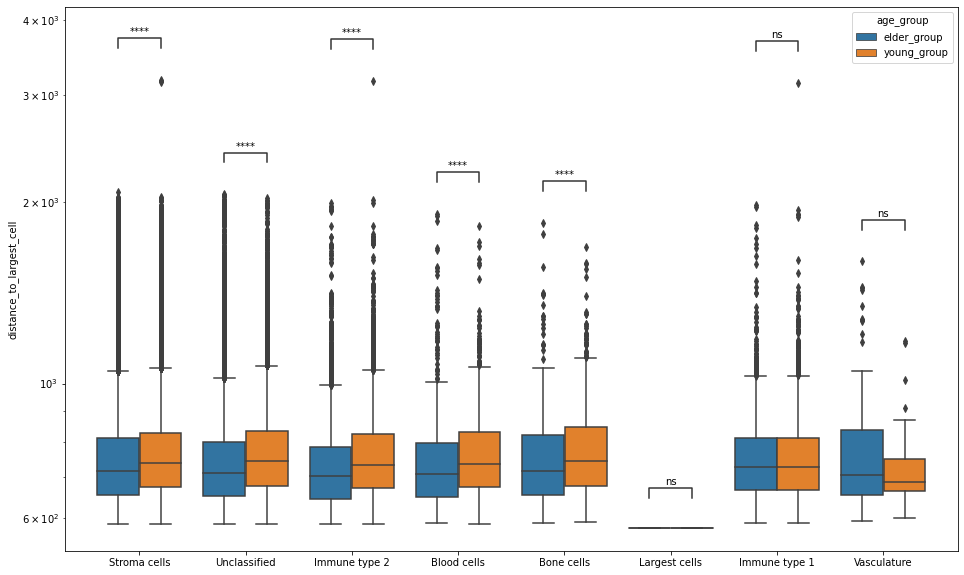

In [38]:
mult_comparisons(
    data, x='cell_type', y='distance_to_largest_cell', hue='age_group', 
    test='Mann-Whitney', test_mult='k', log_scale=True
)

**Вывод:** H0 отклоняем - имеются различия в расстоянии до крупных клеток между разными типами клеток. Кроме того, для большинства клеток имеются статистически значимые различия в расстоянии до крупных клеток в зависимости от возрастной группы.  

Проводим post-hoc анализ отдельно для молодых и пожилых пациентов.  
У молодых пациентов имеются различия в расстоянии до крупных клеток преимущественно для иммунных клеток обоих типов.  
У пожилых расстояния до крупных клеток значимо отличаются только в для иммунных клеток 2 типа (см. ниже).

In [39]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'young_group']['distance_to_largest_cell'],
    data[data['age_group'] == 'young_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells    7.4946 0.5742   -4.6761   19.6653  False
  Blood cells Immune type 1   -11.214 0.0304  -21.8536   -0.5745   True
  Blood cells Immune type 2   -2.7031 0.9895  -12.2395    6.8332  False
  Blood cells Largest cells -190.4013    0.0 -205.2567 -175.5459   True
  Blood cells  Stroma cells     1.536 0.9994   -7.0168   10.0887  False
  Blood cells  Unclassified    6.9472 0.2312   -1.7518   15.6462  False
  Blood cells   Vasculature  -39.1228 0.4271  -96.0956     17.85  False
   Bone cells Immune type 1  -18.7086    0.0  -29.5537   -7.8635   True
   Bone cells Immune type 2  -10.1977 0.0333  -19.9629   -0.4325   True
   Bone cells Largest cells -197.8959    0.0 -212.8992 -182.8926   True
   Bone cells  Stroma cells   -5.9586 0.4475  -14.7658    2.8486

In [40]:
tukey_test = pairwise_tukeyhsd(
    data[data['age_group'] == 'elder_group']['distance_to_largest_cell'],
    data[data['age_group'] == 'elder_group']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells   -0.9088    1.0  -33.4247   31.6071  False
  Blood cells Immune type 1    -6.191 0.9948  -30.7363   18.3543  False
  Blood cells Immune type 2  -30.2607 0.0008  -52.2729   -8.2485   True
  Blood cells Largest cells -190.2724   -0.0 -217.1416 -163.4031   True
  Blood cells  Stroma cells   -6.2932  0.987  -27.7046   15.1181  False
  Blood cells  Unclassified  -13.8634 0.5146  -35.3863    7.6595  False
  Blood cells   Vasculature   32.6904 0.6181  -22.2666   87.6473  False
   Bone cells Immune type 1   -5.2822 0.9991  -32.7263    22.162  False
   Bone cells Immune type 2  -29.3519 0.0099   -54.556   -4.1478   True
   Bone cells Largest cells -189.3636   -0.0 -218.9045 -159.8226   True
   Bone cells  Stroma cells   -5.3844 0.9979  -30.0655   19.2966

___
# Problem 2
#### В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction).

In [41]:
# Group and calculate number of cells
community_cell_count = pd.pivot_table(
    data, 
    index=['cell_interaction', 'case_id'], 
    columns=['cell_type'],
    values='age_group',
    aggfunc=len
).fillna(0).reset_index()

cell_count = pd.melt(
    community_cell_count, 
    value_vars=community_cell_count.columns[2:], 
    var_name='cell_type', 
    value_name='cell_number', 
    id_vars='cell_interaction'
)
cell_count.head(3)

,cell_interaction,cell_type,cell_number
0,community_1,Blood cells,37.0
1,community_1,Blood cells,155.0
2,community_1,Blood cells,42.0


##### Проверка нормальности распределения в группах для количества клеток.
Тесты те же.

Shapiro Test for Blood cells:	p = 0.19974
Shapiro Test for Bone cells:	p = 0.65661
Shapiro Test for Immune type 1:	p = 0.20044
Shapiro Test for Immune type 2:	p = 0.97912
Shapiro Test for Largest cells:	p = 0.25546
Shapiro Test for Stroma cells:	p = 0.11373
Shapiro Test for Unclassified:	p = 0.06949
Shapiro Test for Vasculature:	p = 0.00496


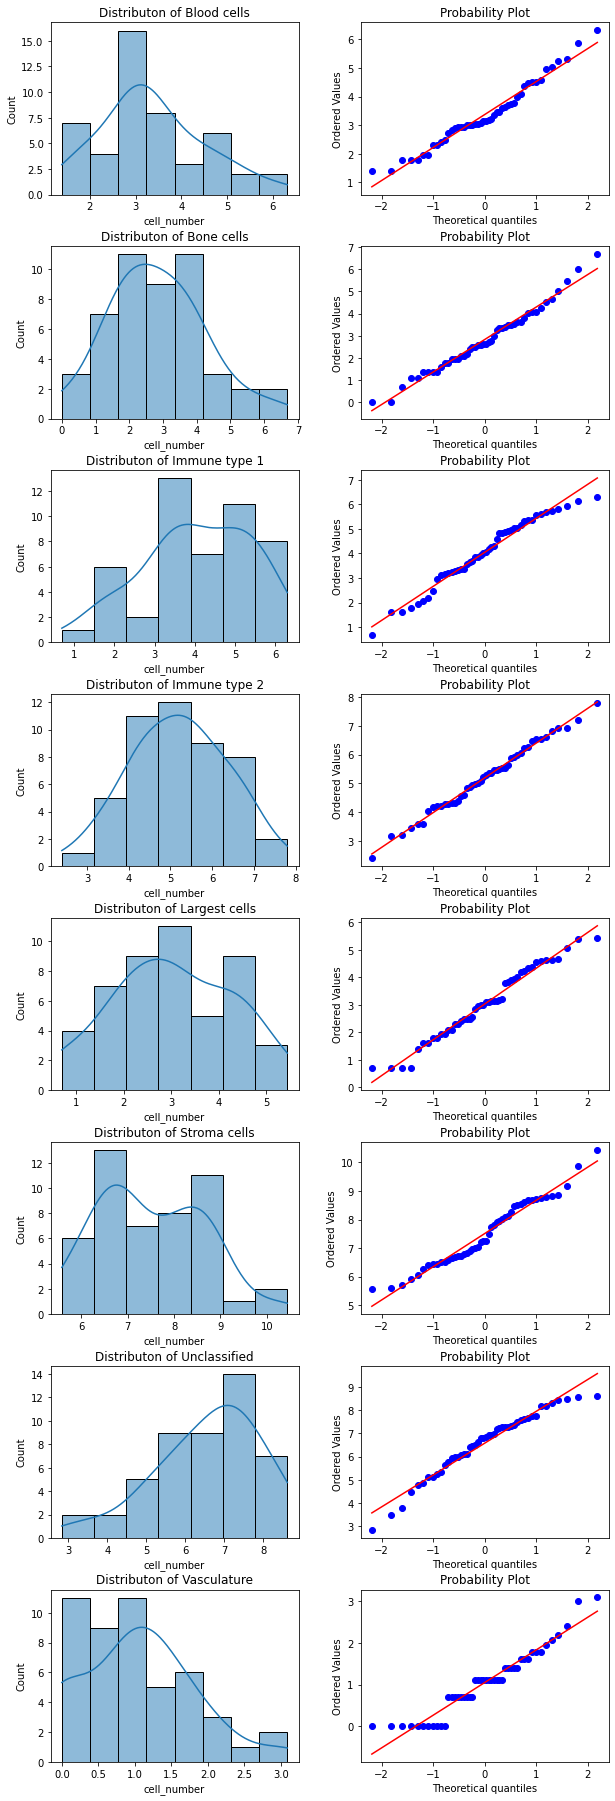

In [42]:
check_normality(
    cell_count, feature='cell_number', 
    groups='cell_type', log_scale=True
)

In [43]:
cell_count[
    (cell_count['cell_interaction']=='community_1')
]['cell_type'].value_counts()

Blood cells      8
Bone cells       8
Immune type 1    8
Immune type 2    8
Largest cells    8
Stroma cells     8
Unclassified     8
Vasculature      8
Name: cell_type, dtype: int64

**Вывод:** Большинство фичей распределено нормально, однако количество наблюдений в каждой подгруппе равно 8, поэтому используем непараметрические тесты.  

**H0** → µ1 = µ2 = µ3 = µ4 = µ5 = µ6 = µ7 = µ8  
**H1** → µ1 != µ2 != µ3 != µ4 != µ5 != µ6 != µ7 != µ8  

tests: [Kruskal-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

alpha = 0.05

Kruskal-Wallis (cell_number btw. cell_type): p = 7.161376654651784e-56



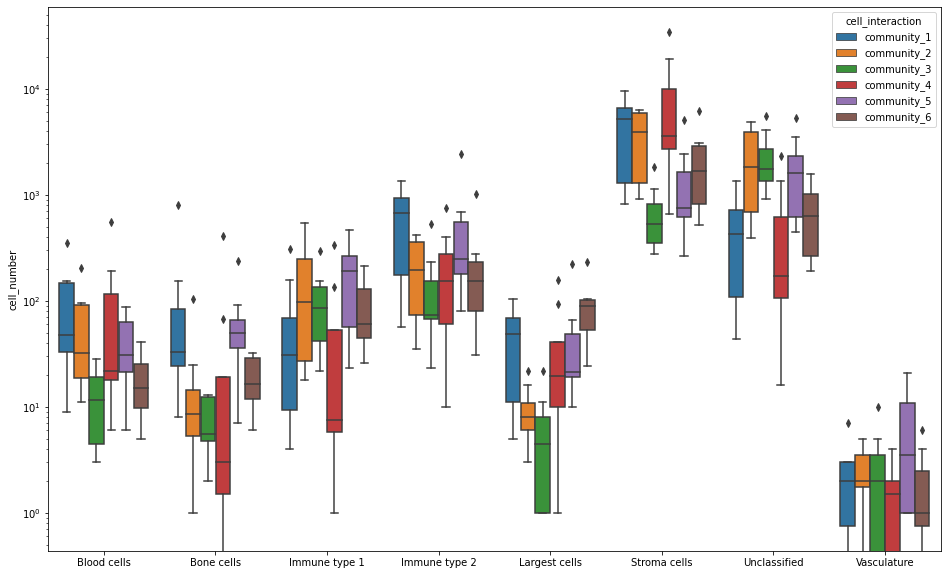

In [44]:
mult_comparisons(
    cell_count, x='cell_type', y='cell_number', hue='cell_interaction', 
    test_mult='k', log_scale=True
)

**Вывод:** H0 отклоняем - имеются различия в количестве клеток между микроокружениями.    

Проводим post-hoc анализ отдельно для каждого микроокружения (см. ниже).  
В 1, 4 и 6 микроокружениях статистически значимо больше стромальных клеток.  
Во 2 и 5 микроокружениях преобладают стромальные и неклассифицированные клетки (между собой статистически не различаясь по количеству).  
В 3 микроокружении статистически значимо больше неклассифицированных клеток.  

In [45]:
tukey_test = pairwise_tukeyhsd(
    cell_count[cell_count['cell_interaction'] == 'community_1']['cell_number'],
    cell_count[cell_count['cell_interaction'] == 'community_1']['cell_type'],
    alpha=0.05
)
print(tukey_test)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1        group2     meandiff p-adj    lower      upper    reject
-------------------------------------------------------------------------
  Blood cells    Bone cells     39.75    1.0 -1796.6432  1876.1432  False
  Blood cells Immune type 1   -28.625    1.0 -1865.0182  1807.7682  False
  Blood cells Immune type 2   521.875 0.9854 -1314.5182  2358.2682  False
  Blood cells Largest cells   -54.875    1.0 -1891.2682  1781.5182  False
  Blood cells  Stroma cells  4476.125    0.0  2639.7318  6312.5182   True
  Blood cells  Unclassified    399.25 0.9971 -1437.1432  2235.6432  False
  Blood cells   Vasculature     -99.0    1.0 -1935.3932  1737.3932  False
   Bone cells Immune type 1   -68.375    1.0 -1904.7682  1768.0182  False
   Bone cells Immune type 2   482.125 0.9908 -1354.2682  2318.5182  False
   Bone cells Largest cells   -94.625    1.0 -1931.0182  1741.7682  False
   Bone cells  Stroma cells  4436.375 

In [46]:
tukey_test = pairwise_tukeyhsd(
    cell_count[cell_count['cell_interaction'] == 'community_2']['cell_number'],
    cell_count[cell_count['cell_interaction'] == 'community_2']['cell_type'],
    alpha=0.05
)
print(tukey_test)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1        group2     meandiff p-adj    lower      upper    reject
-------------------------------------------------------------------------
  Blood cells    Bone cells   -41.375    1.0 -1720.6102  1637.8602  False
  Blood cells Immune type 1   112.125    1.0 -1567.1102  1791.3602  False
  Blood cells Immune type 2    151.25    1.0 -1527.9852  1830.4852  False
  Blood cells Largest cells   -52.625    1.0 -1731.8602  1626.6102  False
  Blood cells  Stroma cells    3585.0    0.0  1905.7648  5264.2352   True
  Blood cells  Unclassified   2241.75 0.0023   562.5148  3920.9852   True
  Blood cells   Vasculature   -59.875    1.0 -1739.1102  1619.3602  False
   Bone cells Immune type 1     153.5    1.0 -1525.7352  1832.7352  False
   Bone cells Immune type 2   192.625    1.0 -1486.6102  1871.8602  False
   Bone cells Largest cells    -11.25    1.0 -1690.4852  1667.9852  False
   Bone cells  Stroma cells  3626.375 

In [47]:
tukey_test = pairwise_tukeyhsd(
    cell_count[cell_count['cell_interaction'] == 'community_3']['cell_number'],
    cell_count[cell_count['cell_interaction'] == 'community_3']['cell_type'],
    alpha=0.05
)
print(tukey_test)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1        group2     meandiff p-adj    lower      upper    reject
-------------------------------------------------------------------------
  Blood cells    Bone cells    -5.125    1.0  -965.9104   955.6604  False
  Blood cells Immune type 1      92.5    1.0  -868.2854  1053.2854  False
  Blood cells Immune type 2   136.375 0.9998  -824.4104  1097.1604  False
  Blood cells Largest cells    -6.125    1.0  -966.9104   954.6604  False
  Blood cells  Stroma cells   694.875 0.3243  -265.9104  1655.6604  False
  Blood cells  Unclassified   2332.25    0.0  1371.4646  3293.0354   True
  Blood cells   Vasculature    -9.875    1.0  -970.6604   950.9104  False
   Bone cells Immune type 1    97.625    1.0  -863.1604  1058.4104  False
   Bone cells Immune type 2     141.5 0.9998  -819.2854  1102.2854  False
   Bone cells Largest cells      -1.0    1.0  -961.7854   959.7854  False
   Bone cells  Stroma cells     700.0 

In [48]:
tukey_test = pairwise_tukeyhsd(
    cell_count[cell_count['cell_interaction'] == 'community_4']['cell_number'],
    cell_count[cell_count['cell_interaction'] == 'community_4']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2    meandiff p-adj    lower      upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells   -54.75    1.0  -6638.591  6529.091  False
  Blood cells Immune type 1   -49.75    1.0  -6633.591  6534.091  False
  Blood cells Immune type 2    108.5    1.0  -6475.341  6692.341  False
  Blood cells Largest cells  -74.125    1.0  -6657.966  6509.716  False
  Blood cells  Stroma cells   8927.0 0.0019   2343.159 15510.841   True
  Blood cells  Unclassified   455.25    1.0  -6128.591  7039.091  False
  Blood cells   Vasculature   -114.0    1.0  -6697.841  6469.841  False
   Bone cells Immune type 1      5.0    1.0  -6578.841  6588.841  False
   Bone cells Immune type 2   163.25    1.0  -6420.591  6747.091  False
   Bone cells Largest cells  -19.375    1.0  -6603.216  6564.466  False
   Bone cells  Stroma cells  8981.75 0.0017   2397.909 15565.591

In [49]:
tukey_test = pairwise_tukeyhsd(
    cell_count[cell_count['cell_interaction'] == 'community_5']['cell_number'],
    cell_count[cell_count['cell_interaction'] == 'community_5']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2    meandiff p-adj    lower      upper   reject
-----------------------------------------------------------------------
  Blood cells    Bone cells   28.625    1.0 -1334.1712 1391.4212  False
  Blood cells Immune type 1  148.375    1.0 -1214.4212 1511.1712  False
  Blood cells Immune type 2  525.625 0.9243  -837.1712 1888.4212  False
  Blood cells Largest cells     11.0    1.0 -1351.7962 1373.7962  False
  Blood cells  Stroma cells   1438.5 0.0316    75.7038 2801.2962   True
  Blood cells  Unclassified  1910.25 0.0012   547.4538 3273.0462   True
  Blood cells   Vasculature   -34.25    1.0 -1397.0462 1328.5462  False
   Bone cells Immune type 1   119.75    1.0 -1243.0462 1482.5462  False
   Bone cells Immune type 2    497.0 0.9428  -865.7962 1859.7962  False
   Bone cells Largest cells  -17.625    1.0 -1380.4212 1345.1712  False
   Bone cells  Stroma cells 1409.875 0.0377    47.0788 2772.6712

In [50]:
tukey_test = pairwise_tukeyhsd(
    cell_count[cell_count['cell_interaction'] == 'community_6']['cell_number'],
    cell_count[cell_count['cell_interaction'] == 'community_6']['cell_type'],
    alpha=0.05
)
print(tukey_test)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1        group2    meandiff p-adj    lower      upper    reject
------------------------------------------------------------------------
  Blood cells    Bone cells      0.0    1.0 -1110.1231  1110.1231  False
  Blood cells Immune type 1     70.0    1.0 -1040.1231  1180.1231  False
  Blood cells Immune type 2  229.625 0.9979  -880.4981  1339.7481  False
  Blood cells Largest cells     73.0    1.0 -1037.1231  1183.1231  False
  Blood cells  Stroma cells  2175.25    0.0  1065.1269  3285.3731   True
  Blood cells  Unclassified   679.75 0.5384  -430.3731  1789.8731  False
  Blood cells   Vasculature   -17.25    1.0 -1127.3731  1092.8731  False
   Bone cells Immune type 1     70.0    1.0 -1040.1231  1180.1231  False
   Bone cells Immune type 2  229.625 0.9979  -880.4981  1339.7481  False
   Bone cells Largest cells     73.0    1.0 -1037.1231  1183.1231  False
   Bone cells  Stroma cells  2175.25    0.0  1065.1

___
# Problem 3
#### Есть ли разница в доле микроокружения в тканях пациентов разных возрастов?

In [51]:
# Group and calculate percent of cells
community_cell_perc = pd.pivot_table(
    data, 
    index=['age_group', 'case_id'], 
    columns=['cell_interaction'],
    values='cell_type',
    aggfunc=len
).fillna(0)
community_cell_perc = community_cell_perc.div(
    community_cell_perc.sum(axis=1), axis=0
).reset_index()

In [52]:
cell_perc = pd.melt(
    community_cell_perc, 
    value_vars=community_cell_perc.columns[2:], 
    var_name='cell_interaction', 
    value_name='comm_percent', 
    id_vars='age_group'
)
cell_perc.head(3)

,age_group,cell_interaction,comm_percent
0,elder_group,community_1,0.148236
1,elder_group,community_1,0.210779
2,elder_group,community_1,0.093723


##### Проверка нормальности распределения в группах для количества клеток.
Тесты те же.

Shapiro Test for community_1:	p = 0.95213
Shapiro Test for community_2:	p = 0.32732
Shapiro Test for community_3:	p = 0.88754
Shapiro Test for community_4:	p = 0.22521
Shapiro Test for community_5:	p = 0.27507
Shapiro Test for community_6:	p = 0.88115


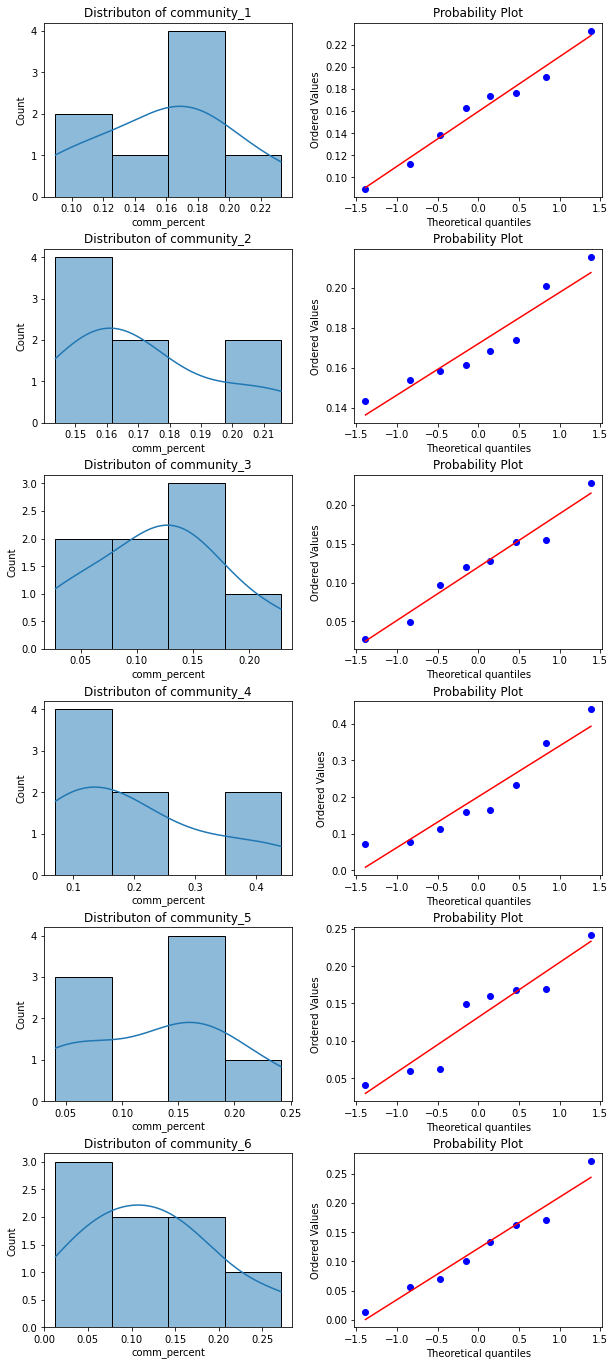

In [53]:
check_normality(
    cell_perc, feature='comm_percent', 
    groups='cell_interaction', log_scale=True
)

In [54]:
cell_perc[
    (cell_perc['age_group']=='young_group')
]['cell_interaction'].value_counts()

community_1    4
community_2    4
community_3    4
community_4    4
community_5    4
community_6    4
Name: cell_interaction, dtype: int64

**Вывод:** Большинство фичей распределено нормально, однако количество наблюдений в каждой подгруппе равно 4, поэтому используем непараметрические тесты.  

**H0** → µ1 = µ2 = µ3 = µ4 = µ5 = µ6   
**H1** → µ1 != µ2 != µ3 != µ4 != µ5 != µ6 

tests: 
- for 2 groups [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) two-sided H1
- for several groups [Kruskal-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)
- [visualizing](https://github.com/trevismd/statannotations)  

alpha = 0.05

Kruskal-Wallis (comm_percent btw. cell_interaction): p = 0.25762935307128176

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

community_2_elder_group vs. community_2_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-01 U_stat=2.000e+00
community_1_elder_group vs. community_1_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:2.000e-01 U_stat=3.000e+00
community_3_elder_group vs. community_3_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-01 U_stat=1.400e+01
community_4_elder_group vs. community_4_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-01 U_stat=2.000e+00
community_5_elder_group vs. community_5_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-01 U_stat=1.400e+01
community_6_elder_group vs. community_6_young_group: Mann-Whitney-Wilcoxon test two-sided, P_val:2.857e-02 U_stat=1.600e+

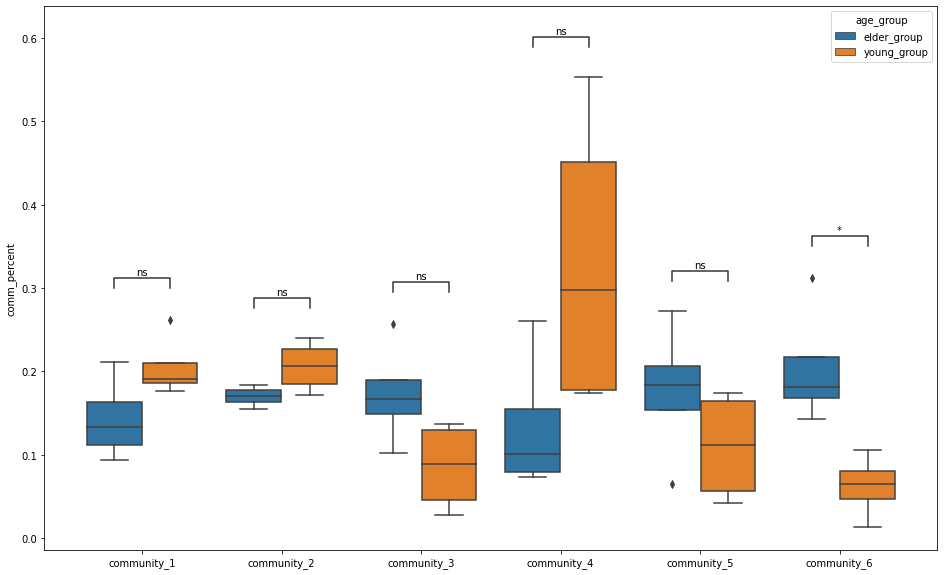

In [55]:
mult_comparisons(
    cell_perc, x='cell_interaction', y='comm_percent', hue='age_group', 
    test='Mann-Whitney', test_mult='k'
)

**Вывод:** H0 принимаем - доли микроокружений статистически не различаются. При сравнении по возрастным группам только доля 6 окружения статистически больше у пожилых пациентов.    

Проводим post-hoc анализ отдельно для каждой возрастной группы (см. ниже).  
У пожилых пациентов доли всех микроокружений одинаковы (статистически не различаются).  
У молоддых пациентов статистически больше доля 4 микроокружения, чем 3, 5 или 6.

In [56]:
tukey_test = pairwise_tukeyhsd(
    cell_perc[cell_perc['age_group'] == 'young_group']['comm_percent'],
    cell_perc[cell_perc['age_group'] == 'young_group']['cell_interaction'],
    alpha=0.05
)
print(tukey_test)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
community_1 community_2   0.0008    1.0 -0.1967  0.1982  False
community_1 community_3  -0.1193 0.4221 -0.3168  0.0782  False
community_1 community_4   0.1256 0.3694 -0.0719   0.323  False
community_1 community_5  -0.0958  0.644 -0.2933  0.1017  False
community_1 community_6   -0.143 0.2436 -0.3405  0.0545  False
community_2 community_3  -0.1201 0.4155 -0.3176  0.0774  False
community_2 community_4   0.1248 0.3756 -0.0727  0.3223  False
community_2 community_5  -0.0965 0.6367  -0.294  0.1009  False
community_2 community_6  -0.1438 0.2389 -0.3413  0.0537  False
community_3 community_4   0.2449 0.0105  0.0474  0.4424   True
community_3 community_5   0.0235 0.9988 -0.1739   0.221  False
community_3 community_6  -0.0237 0.9988 -0.2212  0.1738  False
community_4 community_5  -0.2213  0.023 -0.4188 -0.0238

In [57]:
tukey_test = pairwise_tukeyhsd(
    cell_perc[cell_perc['age_group'] == 'elder_group']['comm_percent'],
    cell_perc[cell_perc['age_group'] == 'elder_group']['cell_interaction'],
    alpha=0.05
)
print(tukey_test)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
community_1 community_2   0.0272 0.9917 -0.1238 0.1782  False
community_1 community_3   0.0302 0.9866 -0.1208 0.1812  False
community_1 community_4  -0.0089    1.0   -0.16 0.1421  False
community_1 community_5   0.0335  0.979 -0.1175 0.1845  False
community_1 community_6   0.0615 0.7842 -0.0895 0.2125  False
community_2 community_3    0.003    1.0  -0.148  0.154  False
community_2 community_4  -0.0361 0.9708 -0.1871 0.1149  False
community_2 community_5   0.0063    1.0 -0.1447 0.1573  False
community_2 community_6   0.0343 0.9766 -0.1167 0.1853  False
community_3 community_4  -0.0391 0.9592 -0.1902 0.1119  False
community_3 community_5   0.0033    1.0 -0.1477 0.1543  False
community_3 community_6   0.0313 0.9843 -0.1197 0.1823  False
community_4 community_5   0.0424 0.9434 -0.1086 0.1934  False
communit

___
# Problem 4
#### Правда ли, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

##### Бутстрап для `distance_to_vasculature` в группе молодых

In [58]:
# Create target features
young_imm_vasc = data[
    (data['age_group'] == 'young_group') 
    & (data['cell_type'].str.startswith('Immune'))
]['distance_to_vasculature'].values

young_st_vasc = data[
    (data['age_group'] == 'young_group') 
    & (data['cell_type'] == 'Stroma cells')
]['distance_to_vasculature'].values

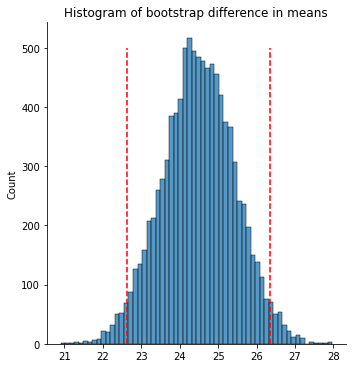

In [59]:
young_boot_vasc = bootstrap(young_imm_vasc, young_st_vasc)

In [60]:
print(f"95% CI of boot data:\t{young_boot_vasc['quants']}\n\
Min value of boot data:\t{min(young_boot_vasc['boot_data'])}")

95% CI of boot data:	(22.639406678202104, 26.35374468346875)
Min value of boot data:	20.900851430182666


**Вывод:** 95% ДИ для разницы средних не пересекает 0, таким образом, по данным бутстрапа у молодых иммунные клетки лежат ближе к сосудам, чем стромальные клетки.

##### Бутстрап для `distance_to_vasculature` в группе пожилых

In [61]:
elder_imm_vasc = data[
    (data['age_group'] == 'elder_group') 
    & (data['cell_type'].str.startswith('Immune'))
]['distance_to_vasculature'].values

elder_st_vasc = data[
    (data['age_group'] == 'elder_group') 
    & (data['cell_type'] == 'Stroma cells')
]['distance_to_vasculature'].values

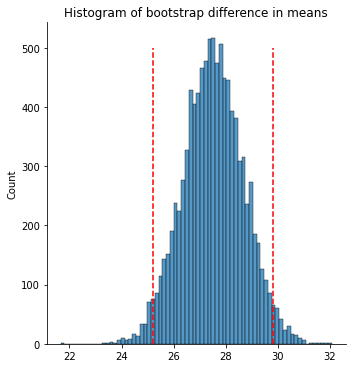

In [62]:
elder_boot_vasc = bootstrap(elder_imm_vasc, elder_st_vasc)

In [63]:
print(f"95% CI of boot data:\t{elder_boot_vasc['quants']}\n\
Min value of boot data:\t{min(elder_boot_vasc['boot_data'])}")

95% CI of boot data:	(25.208533957349818, 29.81949479774666)
Min value of boot data:	21.66448797921454


**Вывод:** 95% ДИ для разницы средних не пересекает 0, таким образом, по данным бутстрапа у пожилых иммунные клетки также лежат ближе к сосудам, чем стромальные клетки.

##### Бутстрап для `distance_to_largest_cell` в группе молодых

In [64]:
young_imm_lc = data[
    (data['age_group'] == 'young_group') 
    & (data['cell_type'].str.startswith('Immune'))
]['distance_to_largest_cell'].values

young_st_lc = data[
    (data['age_group'] == 'young_group') 
    & (data['cell_type'] == 'Stroma cells')
]['distance_to_largest_cell'].values

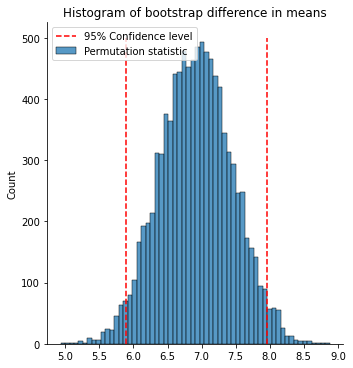

In [78]:
young_boot_lc = bootstrap(young_imm_lc, young_st_lc)

In [66]:
print(f"95% CI of boot data:\t{young_boot_lc['quants']}\n\
Min value of boot data:\t{min(young_boot_lc['boot_data'])}")

95% CI of boot data:	(5.884056647566232, 7.956088736759274)
Min value of boot data:	5.051557244981558


**Вывод:** 95% ДИ для разницы средних не пересекает 0, таким образом, по данным бутстрапа у молодых иммунные клетки также лежат ближе к крупным клеткам, чем стромальные клетки.

##### Бутстрап для `distance_to_largest_cell` в группе пожилых

In [67]:
elder_imm_lc = data[
    (data['age_group'] == 'elder_group') 
    & (data['cell_type'].str.startswith('Immune'))
]['distance_to_largest_cell'].values

elder_st_lc = data[
    (data['age_group'] == 'elder_group') 
    & (data['cell_type'] == 'Stroma cells')
]['distance_to_largest_cell'].values

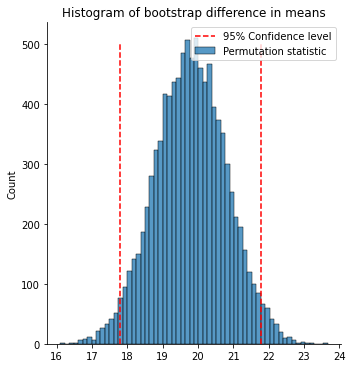

In [77]:
elder_boot_lc = bootstrap(elder_imm_lc, elder_st_lc)

In [69]:
print(f"95% CI of boot data:\t{elder_boot_lc['quants']}\n\
Min value of boot data:\t{min(elder_boot_lc['boot_data'])}")

95% CI of boot data:	(17.833184474411024, 21.76297900507678)
Min value of boot data:	15.995650474083428


**Вывод:** 95% ДИ для разницы средних не пересекает 0, таким образом, по данным бутстрапа у пожилых иммунные клетки также лежат ближе к крупным клеткам, чем стромальные клетки.
___
# Problem 5
#### Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов? Эту гипотезу необходимо проверить пермутационным тестом. В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей! колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы. Комбинировать p-values для каждой возрастной группы можно с помощью этого инструмента.

##### Пермутационный тест для молодых пациентов.

In [70]:
# Create target features for both types of immune cells
young_imm_mean_1 = data[
    (data['age_group'] == 'young_group')
    & (data['cell_type'] == 'Immune type 1')
].groupby(['case_id'])['distance_to_vasculature'].mean().values
young_imm_all_1 = data[
    (data['age_group'] == 'young_group') 
    & (data['cell_type'] == 'Immune type 1')
]

young_imm_mean_2 = data[
    (data['age_group'] == 'young_group')
    & (data['cell_type'] == 'Immune type 2')
].groupby(['case_id'])['distance_to_vasculature'].mean().values
young_imm_all_2 = data[
    (data['age_group'] == 'young_group')
    & (data['cell_type'] == 'Immune type 2')
]

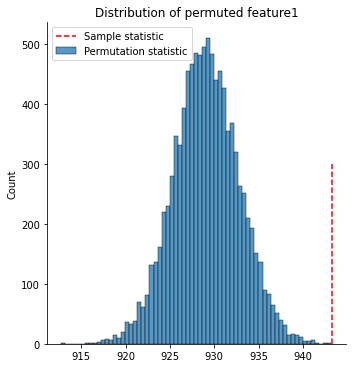

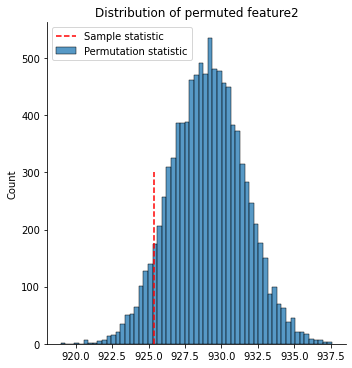

In [71]:
p_young = permutation_test(
    data['distance_to_vasculature'],
    feature1=young_imm_mean_1, feature2=young_imm_mean_2,
    n1=young_imm_all_1.shape[0], n2=young_imm_all_2.shape[0]    
)

In [72]:
print(f"Combined p-value:\t{p_young[0]}\n\
Immune type 1, p-value:\t{p_young[1]}\n\
Immune type 2, p-value:\t{p_young[2]}")

Combined p-value:	0.24891544634890692
Immune type 1, p-value:	1.0
Immune type 2, p-value:	0.0673


**Вывод:** По пермутационному тесту у молодых иммунные клетки 2 типа имеют тенденцию быть ближе к сосудам, чем все остальные клетки. Однако с принятым уровнем значимости 0.05, мы не подтвердили гипотезу, что иммунные клетки лежат ближе к сосудам, чем другие клетки у молодых пациентов.  

##### Пермутационный тест для пожилых пациентов.

In [73]:
elder_imm_mean_1 = data[
    (data['age_group'] == 'elder_group')
    & (data['cell_type'] == 'Immune type 1')
].groupby(['case_id'])['distance_to_vasculature'].mean().values
elder_imm_all_1 = data[
    (data['age_group'] == 'elder_group') 
    & (data['cell_type'] == 'Immune type 1')
]

elder_imm_mean_2 = data[
    (data['age_group'] == 'elder_group')
    & (data['cell_type'] == 'Immune type 2')
].groupby(['case_id'])['distance_to_vasculature'].mean().values
elder_imm_all_2 = data[
    (data['age_group'] == 'elder_group')
    & (data['cell_type'] == 'Immune type 2')
]

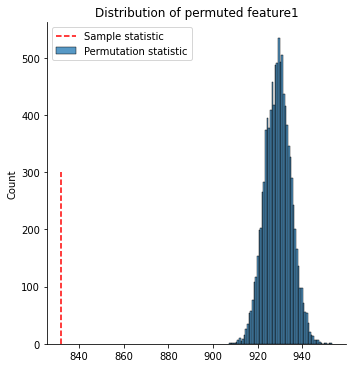

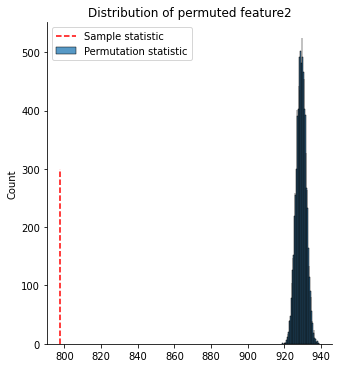

In [74]:
p_elder = permutation_test(
    data['distance_to_vasculature'],
    feature1=elder_imm_mean_1, feature2=elder_imm_mean_2,
    n1=elder_imm_all_1.shape[0], n2=elder_imm_all_2.shape[0]    
)

In [75]:
print(f"Combined p-value:\t{p_elder[0]}\n\
Immune type 1, p-value:\t{p_elder[1]}\n\
Immune type 2, p-value:\t{p_elder[2]}")

Combined p-value:	0.0
Immune type 1, p-value:	0.0
Immune type 2, p-value:	0.0


**Вывод:** По пермутационному тесту мы подтвердили гипотезу, что иммунные клетки лежат ближе к сосудам, чем другие клетки у пожилых пациентов, в отличие от молодых.  